# Парсер Google Trends (selenium)

In [19]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

import time
import pickle
import csv
import numpy as np
import pandas as pd
import re
import os  # позволяет удалять файлы прямо из питона

from matplotlib import pyplot as plt
%matplotlib inline

## Функции для парсинга Google-trends

In [212]:
def open_and_save(words, sleep_time=10):
    """
    Скачивает по пятёркам слов csv-таблички в папку загрузки
        words list(str)
            лист из слов (максимум 5 штук)
        sleep_time float (параметр)
            время для задержки 
    """
    
    words = ', '.join(words)
    
    driver=webdriver.Chrome()
    time.sleep(sleep_time)
    driver.get("https://www.google.ru/trends/explore?date=all&geo=RU&q="+words)
    time.sleep(sleep_time)  # иначе страница не успевает подгрузиться
    
    csv_knopka = driver.find_element_by_xpath('/html/body/div[2]/div[2]/div/md-content/div/div/div[1]/trends-widget/ng-include/widget/div/div/div/widget-actions/div/button[1]/i')
    csv_knopka.click()
    time.sleep(sleep_time)
    driver.close()
    pass


def topic_top(topic, path = '/Users/fulyankin/Downloads'):
    """
    Ишет в среди всех слов коллекци самое интенсивно гуглимое
        topic list (str)
            лист из слов (максимум неограничен, внутри функции идёт дробление на пятёрки)
    """
    
    # Условие выхода из рекурсии
    if len(topic) == 1:
        print('\n \n')
        return topic[0]
    
    # Дробим все слова на пятёрки 
    fives = [topic[5*i:5*(i+1)] for i in range(len(topic)//5)]
    if len(topic)%5 != 0 :
        fives += [topic[-(len(topic)%5) :]]
    print(fives)
    
    # Ищем топ в каждой из пятерок
    top = []
    for item in fives:
        print(item)
        open_and_save(item)  # сохраняем csv с динамикой поиска по первой пятёрке
        time.sleep(3)
        df = pd.read_csv(path+'/multiTimeline.csv', header=1, sep=',') # считываем
        s = ((df == 100)|(df == '100')).sum()[1:]  # Находим самое популярное наименование 
        most_pop = s[s == 1].index[0]
        print(most_pop)
        top.append(most_pop.split(':')[0])   # отсекаем называние региона и закидываем его в список 
        os.remove(path+'/multiTimeline.csv') # удаляем таблицу, которую мы скачали     
    print(top)
    # Рекурсивно зацикливаем функцию
    return topic_top(top)


def topic_download(tpic, best, path = '/Users/fulyankin/Downloads'):
    """
    Выгружает статистику по всем словам в коллекции вместе с топ-словом
        topic list (str)
            лист из слов (максимум неограничен, внутри функции идёт дробление на четвёрки)
        best str
            самое часто гуглимое слово 
    """
    topic = tpic.copy()
    topic.remove(best)      # удяляем из коллекции самое частое слово 
    data = pd.DataFrame( )  # сюда будем закидывать новые таблички
    
    # Дробим все слова на четвёрки 
    foves = [topic[4*i:4*(i+1)] for i in range(len(topic)//4)]
    if len(topic)%4 != 0 :
        foves += [topic[-(len(topic)%4) :]]
    print(foves)

    # Сразу же разбираемся с последним элементом, годом и датой. 
    open_and_save([best] + foves[-1])
    time.sleep(3)
    df = pd.read_csv(path+'/multiTimeline.csv', header=1, sep=',')
    data[df.columns]=df[df.columns]
    os.remove(path+'/multiTimeline.csv')

    # Во всех оставшихся таблицах игнорируем самое популярное слово и месяц
    for item in foves[:(len(foves)-1)]:
        open_and_save([best] + item)
        time.sleep(3)
        df = pd.read_csv(path+'/multiTimeline.csv', header=1, sep=',')
        data[df.columns[2:]]=df[df.columns[2:]]
        os.remove(path+'/multiTimeline.csv')
    return(data)


def self_download(topic, path = '/Users/fulyankin/Downloads'):
    """
    Выгружает статистику по всем словам в коллекции по одному
        topic list (str)
            лист из слов (максимум неограничен, внутри функции идёт дробление на одинарные слова)
    """
    
    data = pd.DataFrame( )  # сюда будем закидывать новые слова

    # Сразу же разбираемся с последним элементом, годом и датой. 
    open_and_save([topic[-1]])
    time.sleep(3)
    df = pd.read_csv(path+'/multiTimeline.csv', header=1, sep=',')
    data[df.columns]=df[df.columns]
    os.remove(path+'/multiTimeline.csv')

    # Во всех оставшихся игнорируем месяц
    for item in topic[:(len(topic)-1)]:
        print(item, data.shape)
        open_and_save([item])
        time.sleep(3)
        df = pd.read_csv(path+'/multiTimeline.csv', header=1, sep=',')
        data[df.columns[1:]]=df[df.columns[1:]]
        os.remove(path+'/multiTimeline.csv')
    return(data)


## Скачка кризисных дескрипторов для индекса поиска

In [175]:
krizis = ['банк', 'курс доллара', 'евро', 'ЦБ', 'РТС', 'ММВБ', 'акция', 'ипотека', 
          'взять кредит', 'ПИФ', 'банкротство', 'залог', 'дефолт', 'девальвация', 
          'финансовый кризис']

top_word = topic_top(krizis)

df_poisk = topic_download(krizis, top_word)

[['банк', 'курс доллара', 'евро', 'ЦБ', 'РТС'], ['ММВБ', 'акция', 'ипотека', 'взять кредит', 'ПИФ'], ['банкротство', 'залог', 'дефолт', 'девальвация', 'финансовый кризис']]
['банк', 'курс доллара', 'евро', 'ЦБ', 'РТС']
курс доллара: (Россия)
['ММВБ', 'акция', 'ипотека', 'взять кредит', 'ПИФ']
ипотека: (Россия)
['банкротство', 'залог', 'дефолт', 'девальвация', 'финансовый кризис']
финансовый кризис: (Россия)
['курс доллара', 'ипотека', 'финансовый кризис']
[['курс доллара', 'ипотека', 'финансовый кризис']]
['курс доллара', 'ипотека', 'финансовый кризис']
курс доллара: (Россия)
['курс доллара']
[['банк', 'евро', 'ЦБ', 'РТС'], ['ММВБ', 'акция', 'ипотека', 'взять кредит'], ['ПИФ', 'банкротство', 'залог', 'дефолт'], ['девальвация', 'финансовый кризис']]


In [176]:
df_poisk.head()

,Месяц,курс доллара: (Россия),девальвация: (Россия),финансовый кризис: (Россия),банк: (Россия),евро: (Россия),ЦБ: (Россия),РТС: (Россия),ММВБ: (Россия),акция: (Россия),ипотека: (Россия),взять кредит: (Россия),ПИФ: (Россия),банкротство: (Россия),залог: (Россия),дефолт: (Россия)
0,2004-01,5,0,0,27,4,3,<1,1,<1,<1,0,0,1,<1,0
1,2004-02,4,0,0,25,4,1,<1,<1,<1,2,0,1,<1,2,0
2,2004-03,3,0,0,36,3,2,1,1,1,2,0,2,1,0,1
3,2004-04,3,0,0,36,2,3,0,<1,2,1,<1,1,0,<1,0
4,2004-05,4,0,0,31,5,4,1,1,1,3,0,0,1,<1,<1


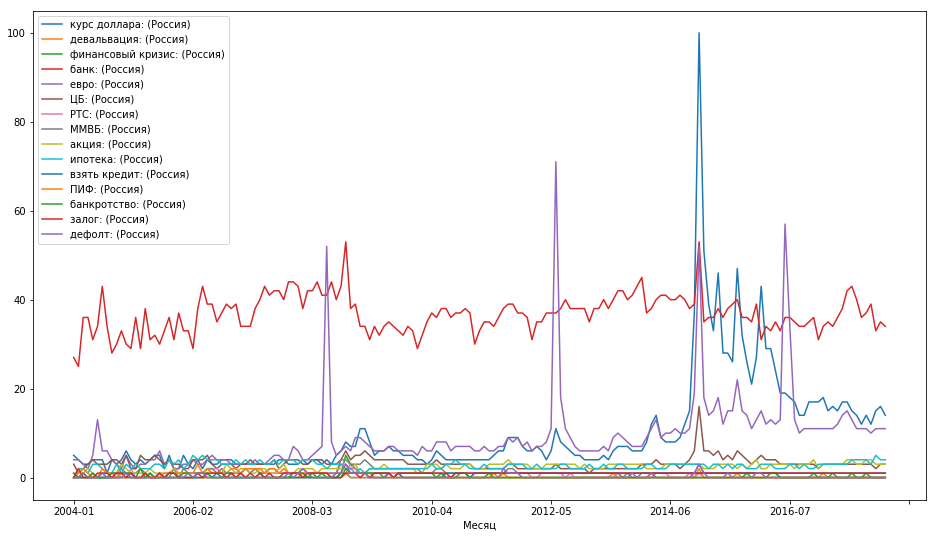

In [202]:
df_poisk = df_poisk.replace({'<1' : 0})
for item in df_poisk.columns[1:]:
    df_poisk[item] = df_poisk[item].astype(float)

df_poisk.set_index('Месяц').plot(legend=True, figsize=(16,9))

In [205]:
df_poisk.to_csv('../data/data_simple_index/krizis_poisk.csv' )

In [213]:
df_poisk_odinar = self_download(krizis)

банк (171, 2)
курс доллара (171, 3)
евро (171, 4)
ЦБ (171, 5)
РТС (171, 6)
ММВБ (171, 7)
акция (171, 8)
ипотека (171, 9)
взять кредит (171, 10)
ПИФ (171, 11)
банкротство (171, 12)
залог (171, 13)
дефолт (171, 14)
девальвация (171, 15)


In [214]:
df_poisk_odinar.head()

,Месяц,финансовый кризис: (Россия),банк: (Россия),курс доллара: (Россия),евро: (Россия),ЦБ: (Россия),РТС: (Россия),ММВБ: (Россия),акция: (Россия),ипотека: (Россия),взять кредит: (Россия),ПИФ: (Россия),банкротство: (Россия),залог: (Россия),дефолт: (Россия),девальвация: (Россия)
0,2004-01,0,50,5,6,22,14,25,12,10,0,20,28,72,15,0
1,2004-02,0,47,4,6,9,14,12,12,37,0,20,0,35,0,0
2,2004-03,0,67,3,4,15,34,29,14,45,0,23,100,42,17,0
3,2004-04,0,67,3,2,16,0,11,10,16,29,34,48,31,13,0
4,2004-05,0,57,4,7,25,33,19,27,52,0,31,0,0,0,0


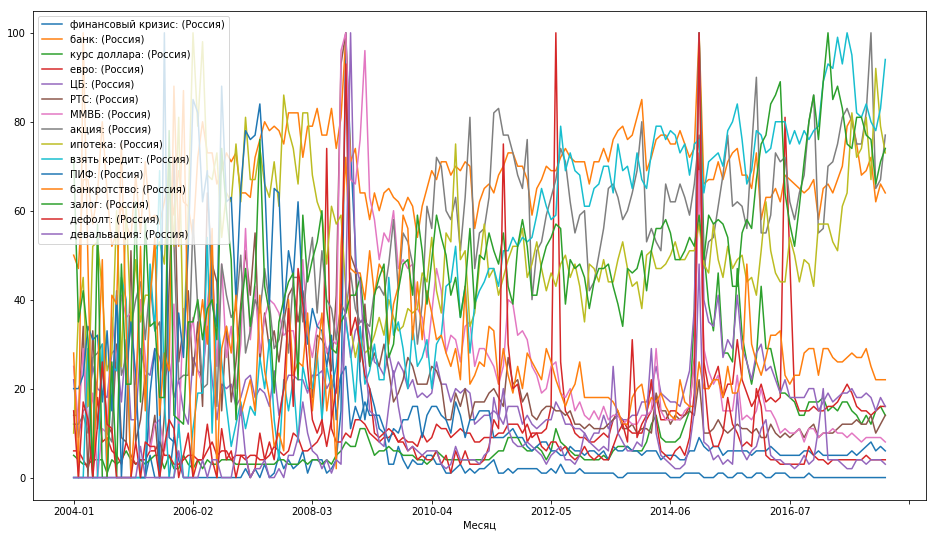

In [215]:
df_poisk_odinar = df_poisk_odinar.replace({'<1' : 0})
for item in df_poisk_odinar.columns[1:]:
    df_poisk_odinar[item] = df_poisk_odinar[item].astype(float)

df_poisk_odinar.set_index('Месяц').plot(legend=True, figsize=(16,9))

In [216]:
df_poisk_odinar.to_csv('../data/data_simple_index/krizis_poisk_odinar.csv' )

## Скачка дескрипторов по темам из кластеризации новостей

### Подготовка входных данных

In [ ]:
path = '/home/filipp/Yandex.Disk/Дисертация/python(scripts)/wikipedia/PLSA_100'
with open(path+'/plsa_lemm_100_maxtf_100000_top_tokens.pickle', 'rb') as f:
    top_tokens = pickle.load(f)

In [ ]:
names = list(top_tokens.keys())
top_tokens = [top_tokens[name] for name in names]

## Тут начинается часть, в которой идёт выкачка

In [ ]:
# Выкачиваем абсолютно всё! Заодно запоминаем все самые популярные слова для будущей совместной выгрузки!
# Функция не просто всё скачает, но ещё и сохранит вектор из топа слов, чтобы мы использовали его на 
# этапе совместной выкачки

def Total_part_downloader(path1,path2):
    with open(path1, 'rb') as f:
        top_tokens = pickle.load(f)

    names = list(top_tokens.keys())
    top_tokens = [top_tokens[name] for name in names]
        
    top_tiptop = [ ]
    l = 65
    for item in top_tokens[65:]:
        best = topic_top(item)
        data = topic_download(item,best)
        data.to_csv(path2 + 'data'+str(l)+'.csv',sep=',',header=True,index=False)
        top_tiptop.append(best)
        l = l + 1
    return(top_tiptop)


path1 = '/home/filipp/Yandex.Disk/Дисертация/python(scripts)/wikipedia/PLSA_100/plsa_lemm_100_maxtf_100000_top_tokens.pickle'
path2 = '/home/filipp/Downloads/data/'
tiptop = Total_part_downloader(path1,path2)